### ToDo
* changing resource state 
* changing setup for each op 
    * may not required as you have the current operation with the req setup
    * and we do not consider setup times.
* monitoring the basics
* Material (Charge, Qualität, usw)
* Vorgänger (und Nachfolger) auf der Maschine speichern (vollständige Historie) --> Erweiterung: Stack/Queue mit "x Elementen" oder einen "x Zeitraum"
* alternative Maschine aus Maschinengruppe nutzen (optional?)
* Giffler - offene Operationen für die Inferencing
* run-event selbst bauen warten bis zum Endschritt 


Wie macht man Effekte sichtbar?
Qualitätsstufen von Materialen

In [ ]:
from models.causal import CausalModel
from models.xgboost import XGBoost
from plan.GifflerThompson import GifflerThompson
from factory.Operation import Operation
from generators.jobs_data_generator import JobsDataGenerator
from plan.PriorityRules import calculate_dynamic_priority, calculate_fcfs_priority

# Beispielhafte Datenstruktur
# Produkt, Arbeitsgang, Maschinengruppe, Tool, geplante Dauer, Nachfolger
template_jobs_data = [
    ['p1', 1, 'a1', 1, 30, 4],
    ['p1', 2, 'a2', 1, 45, 4],
    ['p1', 3, 'a1', 2, 15, 4],
    ['p1', 4, 'a3', 1, 15, -1],
    ['p2', 1, 'a1', 1, 15, 3],
    ['p2', 2, 'a4', 2, 45, 3],
    ['p2', 3, 'a3', 2, 15, 5],
    ['p2', 4, 'a2', 1, 30, 5],
    ['p2', 5, 'a4', 1, 15, -1],
]

generator = JobsDataGenerator(template_jobs_data)
num_instances = 150  # Number of new instances to generate
relation = {'p1': 0.5, 'p2': 0.5}  # Relation of each product type

jobs_data = generator.generate_jobs_data(num_instances, relation)

# Maschinenpools definieren
# id, number, tools 
machine_pools_data = [
    ['a1', 1, [1,2,3]],
    ['a2', 1, [1,2,3]],
    ['a3', 1, [1,2,3]],
    ['a4', 1, [1,2,3]],
#    ['a5', 1, [1,2,3]],
#    ['a6', 1, [1,2,3]],
]


# Konvertiere die jobs_data in Operation-Objekte
operations_causal = [Operation(*data) for data in jobs_data]
operations_non_causal = [Operation(*data) for data in jobs_data]
operations_non_avg_causal = [Operation(*data) for data in jobs_data]
operations_xgboost = [Operation(*data) for data in jobs_data]

# causal model
observed_data = []

csv_file = 'data/observed_data.csv'
model = CausalModel(csv_file=csv_file)
model_correlation = XGBoost(csv_file=csv_file)
# Causal model for simulation
# define an inference rule    
def simulation_inference(operation: Operation, tool) -> int:
 
    # 1. Preperation step
    #has_lots_operations = len(operation.predecessor_operations) > 1
    #is_shorter_than_15 =  operation.plan_duration < 15
    #filtered_pools = [pool for pool in sim.pools.values() if pool.group == operation.machine.group and pool.id != operation.machine.id]
    #one_working = any(pool.current_operation is not None for pool in filtered_pools) 
    
    # 2. Infer step
    inferenced_variables = model.infer_duration(True, operation, tool)

    # 3. Calculation step
    new_duration = round(operation.duration * inferenced_variables['delay'],0)
    
    # Save for causal learning
    observed_data.append([tool, inferenced_variables['machine_status'], inferenced_variables['pre_processing'], inferenced_variables['delay']])

    print(f"Operation duration was: {operation.duration} and has been changed to {new_duration}")
    return new_duration

# Causal model for planning
# define an inference rule
def plan_inference(operation: Operation, tool) -> int:
    
    # 2. Infer step
    inferenced_variables = model.infer_duration(False, operation, tool)

    new_duration = round(operation.duration * inferenced_variables['delay'],0)

    return new_duration

# Causal model for planning
# define an inference rule
def plan_inference_non(operation: Operation, tool) -> int:
    return operation.duration

def plan_inference_with_avg_duration(operation: Operation, tool) -> int:
    return operation.duration * model.avg_duration

def plan_inference_with_xgboost(operation: Operation, tool) -> int:
        
    # 2. Infer step
    inferenced_variables = model_correlation.infer_duration(operation, tool)

    new_duration = round(operation.duration * inferenced_variables['delay'],0)

    return new_duration

#hodgens = HodgsonMooreAlgorithm()
#hodgens_schedule = hodgens.schedule_jobs(operations_non_causal, machine_pools_data)

# Case 1: Causal Learned Model
gt = GifflerThompson(calculate_dynamic_priority, plan_inference)
gt_causal_schedule = gt.giffen_thompson(operations_causal, machine_pools_data)

# Case 2: Non-Causal Model
non_causal = GifflerThompson(calculate_dynamic_priority, plan_inference_non)
gt_non_causal_schedule = non_causal.giffen_thompson(operations_non_causal, machine_pools_data)

# Case 3: Model with average duration delay
non_avg_causal = GifflerThompson(calculate_dynamic_priority, plan_inference_with_avg_duration)
gt_non_avg_causal_schedule = non_avg_causal.giffen_thompson(operations_non_avg_causal, machine_pools_data)

# Case 4: XGBoost Model
non_xgboost = GifflerThompson(calculate_dynamic_priority, plan_inference_with_xgboost)
gt_xgboost_schedule = non_xgboost.giffen_thompson(operations_xgboost, machine_pools_data)



/home/marvin/repo/PlanCausal/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Set edges by user
Set edges by user
Testing combination: Algorithm=exhaustive, Score=K2
Lerne Modell mit exhaustive-Algorithmus und K2-Score
Successful combination: Algorithm=exhaustive, Score=K2
Anzahl der erfolgreich gelernten Modelle:  1
Testing combination: Algorithm=exhaustive, Score=K2
Lerne Modell mit exhaustive-Algorithmus und K2-Score
Successful combination: Algorithm=exhaustive, Score=K2
Number of successful learned models:  1
[0]	test-rmse:0.09957
[1]	test-rmse:0.09954
[2]	test-rmse:0.09950
[3]	test-rmse:0.09941
[4]	test-rmse:0.09946
[5]	test-rmse:0.09951
[6]	test-rmse:0.09954
[7]	test-rmse:0.09945
[8]	test-rmse:0.09945
[9]	test-rmse:0.09943
[10]	test-rmse:0.09944
[11]	test-rmse:0.09946
[12]	test-rmse:0.09956
Model MSE: 0.00990659631145064


In [6]:
from simulation.Simulator import Simulator
from simulation.Monitoring.BasicMonitor import monitorResource
from functools import partial

# array to store monitored data
data = []

# resource monitor [pre , post] execution
monitor = [None, partial(monitorResource, data)]

sim = Simulator(machine_pools_data
                , operations_non_causal
                , monitor
                , simulation_inference)

sim.env.run(12000)

2220
1710
2235
2895
3810
2595
1890
2625
3315
3885
2850
3630
2970
3675
3285
2340
3315
4140
4170
3570
4485
3690
4530
4035
2700
4050
5025
5055
4260
3060
4335
5400
5430
45
75
105
120
420
510
510
555
735
450
750
1005
3405
1110
1350
1200
1395
1395
945
1455
1830
3570
1650
1305
1665
2175
3675
1755
1350
1770
2205
3690
1770
2235
1800
2280
1815
1395
1845
2280
3705
1830
1440
1860
2310
3720
1845
1485
1875
2340
3735
1860
1530
1920
2370
3750
1875
2400
1905
2445
1920
1575
1935
2445
3765
1935
2475
1965
2520
1980
2520
2010
2565
2025
2565
2055
2610
2070
1620
2085
2610
3780
2085
2640
2115
2685
2130
2685
2160
2730
2175
2730
2205
2775
2235
1665
2295
2775
3795
2250
2805
2280
2850
2295
2850
2325
2910
2340
1755
2355
2925
3825
2355
2955
2385
3000
2400
1800
2460
3000
3840
2415
3030
2445
3075
2460
3075
2490
3120
2505
3120
2535
3165
2550
3165
2580
3210
2610
1845
2640
3210
3855
2625
3240
2655
3285
2670
1935
2700
3285
3870
2685
1980
2745
3345
3900
2700
3375
2730
3420
2745
3420
2775
3465
2790
2025
2805
3465
3915
2805

## Some statistics to compare the plan

In [7]:
import pandas as pd

def calculate_makespan(df_schedule, schedule_name):
    # Convert the list of operation objects to a DataFrame
    

    # Calculate start and end times for each job
    grouped_schedule = df_schedule.groupby('job_id').agg({'start_time': 'min', 'end_time': 'max'})

    # Calculate the makespan for each job
    grouped_schedule['makespan'] = grouped_schedule['end_time'] - grouped_schedule['start_time']

    # Calculate the average makespan across all jobs
    average_makespan = grouped_schedule['makespan'].mean()

    # Output the results with the schedule name
    print(f"{schedule_name} | {average_makespan} time units")

print(f"Average makespan across all products: ")
# Example usage with named schedules
calculate_makespan(pd.DataFrame([op.to_dict() for op in gt_non_causal_schedule]), 'NonCausal')
calculate_makespan(pd.DataFrame([op.to_dict() for op in gt_causal_schedule]), 'Causal')
calculate_makespan(pd.DataFrame([op.to_dict() for op in gt_non_avg_causal_schedule]), 'Causal with AVG')
calculate_makespan(pd.DataFrame([op.to_dict() for op in gt_xgboost_schedule]), 'Xgbost')
calculate_makespan(pd.DataFrame([op.to_dict_sim() for op in sim.schedule]), 'Sim')


Average makespan across all products: 
NonCausal | 1466.5 time units
Causal | 1659.48 time units
Causal with AVG | 1593.4043872919844 time units
Xgbost | 1593.4043872919844 time units
Sim | 1617.24 time units


In [8]:
import math

truth_sim = pd.DataFrame([op.to_dict_sim() for op in sim.schedule])
truth_causal = pd.DataFrame([op.to_dict() for op in gt_causal_schedule])

combined_df = pd.merge(truth_sim, truth_causal, on=['job_id', 'operation_id'], how='outer')

#trouth_sim['diff'] = trouth_sim['duration'] - trouth_sim['plan_duration']
#trouth_causal['diff'] = trouth_causal['plan_duration'] - trouth_causal['duration']
#trouth_sim['sim_causal_dif'] = trouth_causal['plan_duration'] - trouth_sim['duration']


combined_df['diff_sim_truth'] = combined_df['duration_x'] - combined_df['plan_duration_x']
combined_df['diff_causal_truth'] = combined_df['plan_duration_y'] - combined_df['duration_y']
combined_df['diff_causal_sim'] = combined_df['duration_x'] - combined_df['plan_duration_y'] 
combined_df[['duration_x','plan_duration_x', 'diff_sim_truth', 'diff_sim_truth', 'diff_causal_sim']].describe()
# combined_df[combined_df['diff_causal_sim'] > 0].head(1000)



,duration_x,plan_duration_x,diff_sim_truth,diff_sim_truth,diff_causal_sim
count,672.000000,672.000000,672.000000,672.000000,672.000000
mean,27.392857,25.044643,2.348214,2.348214,-0.098214
std,13.901736,12.265606,3.095239,3.095239,3.963605
min,15.000000,15.000000,0.000000,0.000000,-9.000000
25%,15.000000,15.000000,0.000000,0.000000,-3.000000
50%,18.000000,15.000000,0.000000,0.000000,0.000000
75%,36.000000,30.000000,3.000000,3.000000,0.000000
max,54.000000,45.000000,9.000000,9.000000,9.000000


In [9]:
df_observed_data = pd.DataFrame(observed_data, columns=['previous_machine_pause' , 'machine_status', 'pre_processing', 'delay'])
df_observed_data.to_csv(csv_file)

Sim result

/tmp/ipykernel_1117000/1685830134.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  job_colors = {job_id: plt.cm.get_cmap('tab20')(i / len(unique_jobs)) for i, job_id in enumerate(unique_jobs)}


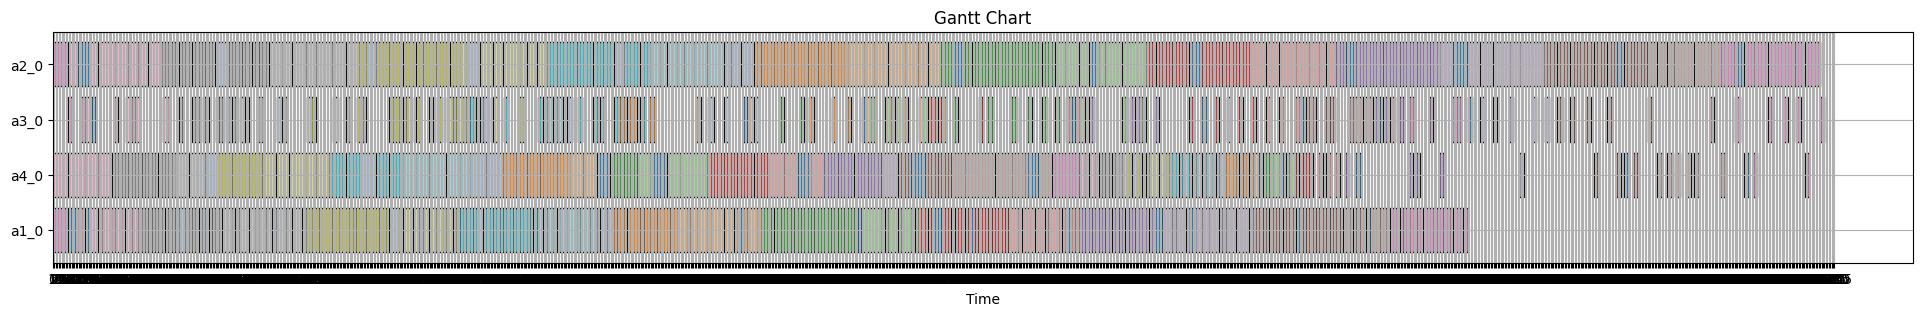

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import math

# Daten in ein DataFrame konvertieren
df = pd.DataFrame([op.to_dict_sim() for op in sim.schedule])

size_height = math.ceil(df["machine"].count().itemsize / 3)
# Gantt-Diagramm erstellen
fig, ax = plt.subplots(figsize=(24, size_height))

# Maschinen als y-Werte für die Balken
machines = df['machine'].unique()
machine_to_y = {machine: i for i, machine in enumerate(machines)}

# Erstelle eine Colormap für die job_ids
unique_jobs = df['job_id'].unique()
job_colors = {job_id: plt.cm.get_cmap('tab20')(i / len(unique_jobs)) for i, job_id in enumerate(unique_jobs)}

# Iteriere über jede Zeile des DataFrames
for i, row in df.iterrows():
    start = row['start_time']
    duration = row['duration']
    job_id = row['job_id']
    task_id = row['operation_id']
    machine = row['machine']
    label = f'{job_id} {task_id}'

    # Verwende die Farbe für den entsprechenden job_id
    color = job_colors[job_id]

    # Stelle die Aufgabe als Balken im Diagramm dar
    ax.barh(y=machine_to_y[machine], left=start, width=duration, height=0.8, align='center', color=color, edgecolor='black')
    
    # Text in den Balken einfügen (optional, falls du das möchtest)
    # ax.text(x=start + duration / 2, y=machine_to_y[machine], s=label, va='center', ha='center', color='black')

# Diagramm formatieren
ax.set_xlabel('Time')
ax.set_yticks(list(machine_to_y.values()))
ax.set_yticklabels(list(machine_to_y.keys()))
ax.set_title('Gantt Chart')
max_time = df['start_time'].max() + df['duration'].max()  # Determine max time to cover full range
ax.set_xticks(range(0, math.ceil(max_time) + 1, 5))

# Grid anzeigen
ax.grid(True)

# Diagramm anzeigen
plt.show()

GT without causal

/tmp/ipykernel_1117000/1553617269.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  job_colors = {job_id: plt.cm.get_cmap('tab20')(i / len(unique_jobs)) for i, job_id in enumerate(unique_jobs)}


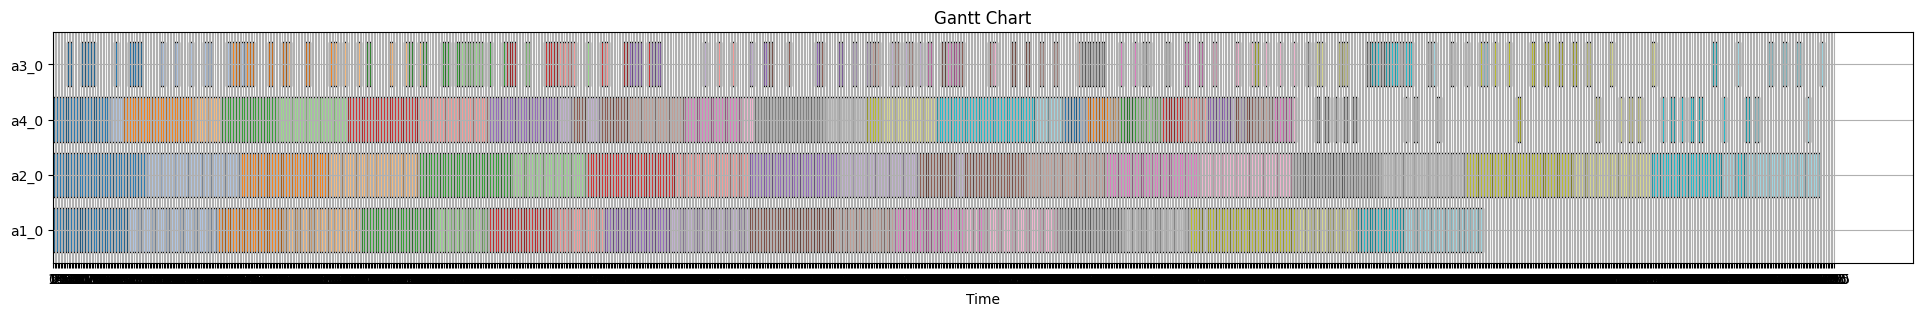

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import math

# Daten in ein DataFrame konvertieren
df = pd.DataFrame([p.to_dict() for p in gt_non_causal_schedule])

size_height = math.ceil(df["machine"].count().itemsize / 3)
# Gantt-Diagramm erstellen
fig, ax = plt.subplots(figsize=(24, size_height))

# Maschinen als y-Werte für die Balken
machines = df['machine'].unique()
machine_to_y = {machine: i for i, machine in enumerate(machines)}

unique_jobs = df['job_id'].unique()
job_colors = {job_id: plt.cm.get_cmap('tab20')(i / len(unique_jobs)) for i, job_id in enumerate(unique_jobs)}

# Iteriere über jede Zeile des DataFrames
for i, row in df.iterrows():
    start = row['start_time']
    duration = row['plan_duration']
    job_id = row['job_id']
    task_id = row['operation_id']
    machine = row['machine']
    label = f'{job_id} {task_id}'

    # Verwende die Farbe für den entsprechenden job_id
    color = job_colors[job_id]

    # Stelle die Aufgabe als Balken im Diagramm dar
    ax.barh(y=machine_to_y[machine], left=start, width=duration, height=0.8, align='center', color=color, edgecolor='black')
    
    # Text in den Balken einfügen
    #ax.text(x=start + duration / 2, y=machine_to_y[machine], s=label, va='center', ha='center', color='black')

# Diagramm formatieren
ax.set_xlabel('Time')
ax.set_yticks(list(machine_to_y.values()))
ax.set_yticklabels(list(machine_to_y.keys()))
ax.set_title('Gantt Chart')
max_time = df['start_time'].max() + df['duration'].max()  # Determine max time to cover full range
ax.set_xticks(range(0, math.ceil(max_time) + 1, 5))
# Grid anzeigen
ax.grid(True)

# Legende entfernen, da sie nicht mehr notwendig ist
# Handles und Labels der Legende deduplizieren
# handles, labels = plt.gca().get_legend_handles_labels()
# by_label = dict(zip(labels, handles))
# plt.legend(by_label.values(), by_label.keys())

# Diagramm anzeigen
plt.show()


GT with Causal

/tmp/ipykernel_1117000/873938610.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  job_colors = {job_id: plt.cm.get_cmap('tab20')(i / len(unique_jobs)) for i, job_id in enumerate(unique_jobs)}


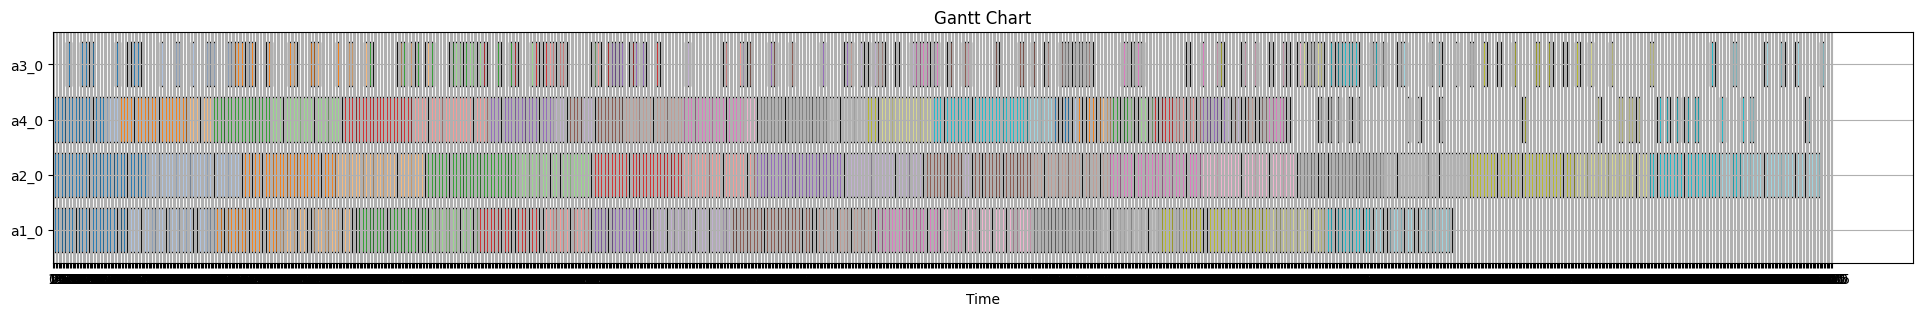

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import math

# Daten in ein DataFrame konvertieren
df = pd.DataFrame([p.to_dict() for p in gt_causal_schedule])

size_height = math.ceil(df["machine"].count().itemsize / 3)
# Gantt-Diagramm erstellen
fig, ax = plt.subplots(figsize=(24, size_height))

# Maschinen als y-Werte für die Balken
machines = df['machine'].unique()
machine_to_y = {machine: i for i, machine in enumerate(machines)}

# Erstelle eine Colormap für die job_ids
unique_jobs = df['job_id'].unique()
job_colors = {job_id: plt.cm.get_cmap('tab20')(i / len(unique_jobs)) for i, job_id in enumerate(unique_jobs)}

# Iteriere über jede Zeile des DataFrames
for i, row in df.iterrows():
    start = row['start_time']
    duration = row['plan_duration']
    job_id = row['job_id']
    task_id = row['operation_id']
    machine = row['machine']
    label = f'{job_id} {task_id}'

    # Verwende die Farbe für den entsprechenden job_id
    color = job_colors[job_id]
    # Stelle die Aufgabe als Balken im Diagramm dar
    ax.barh(y=machine_to_y[machine], left=start, width=duration, height=0.8, align='center', color=color, edgecolor='black')
    
    # Text in den Balken einfügen
    #ax.text(x=start + duration / 2, y=machine_to_y[machine], s=label, va='center', ha='center', color='black')

# Diagramm formatieren
ax.set_xlabel('Time')
ax.set_yticks(list(machine_to_y.values()))
ax.set_yticklabels(list(machine_to_y.keys()))
ax.set_title('Gantt Chart')
max_time = df['start_time'].max() + df['duration'].max()  # Determine max time to cover full range
ax.set_xticks(range(0, math.ceil(max_time) + 1, 5))
# Grid anzeigen
ax.grid(True)

# Legende entfernen, da sie nicht mehr notwendig ist
# Handles und Labels der Legende deduplizieren
# handles, labels = plt.gca().get_legend_handles_labels()
# by_label = dict(zip(labels, handles))
# plt.legend(by_label.values(), by_label.keys())

# Diagramm anzeigen
plt.show()
